In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn import tree
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.model_selection import ParameterGrid
import random
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#initialize the seed
random.seed(123)

In [3]:
data = pd.read_csv('musicData.csv')
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


# Data Preprocessing

In [4]:
data.replace('?', np.nan, inplace=True)
print(data.isna().sum())

# Display rows where 'artist_name' column is NaN
nan_rows_artist_name = data[data['artist_name'].isna()]
print(nan_rows_artist_name)

# Drop rows where the 'artist_name' column is NaN
data = data.dropna(subset=['artist_name'])

print(data.isna().sum())

instance_id            5
artist_name            5
track_name             5
popularity             5
acousticness           5
danceability           5
duration_ms            5
energy                 5
instrumentalness       5
key                    5
liveness               5
loudness               5
mode                   5
speechiness            5
tempo               4985
obtained_date          5
valence                5
music_genre            5
dtype: int64
       instance_id artist_name track_name  popularity  acousticness  \
10000          NaN         NaN        NaN         NaN           NaN   
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10000           NaN          NaN 

In [5]:
#change values in tempo from str to float
data['tempo'] = pd.to_numeric(data['tempo'], errors='coerce')

# Fill NaN values in the 'tempo' column with the median
median_tempo = data['tempo'].median()
data.loc[:, 'tempo'] = data['tempo'].fillna(median_tempo)

In [6]:
# Convert the Non-numerical value to numerical
key_map = {'C': 1, 'C#': 2, 'D': 3, 'D#': 4, 'E': 5, 'F': 6, 'F#': 7, 'G': 8, 'G#': 9, 'A': 10, 'A#': 11, 'B': 12}
data.loc[:, 'key'] = data['key'].replace(key_map)

mode_map = {'Minor':0, 'Major':1}
data.loc[:, 'mode'] = data['mode'].replace(mode_map)

In [7]:
# Convert negative values in 'duration_ms' to NaN
data.loc[data['duration_ms'] < 0, 'duration_ms'] = np.nan

# Fill NaN values with the median of the remaining non-NaN
median_duration = data['duration_ms'].median()
data.loc[:, 'duration_ms'] = data['duration_ms'].fillna(median_duration)

In [8]:
#change genres to numerical labels
genres = data['music_genre'].value_counts().index.tolist()
value_map = {value: index+1 for index, value in enumerate(genres)}
data.loc[:, 'music_genre'] = data['music_genre'].replace(value_map)

In [9]:
# LabelEncoder for mode & key
key_encoder = LabelEncoder()
mode_encoder = LabelEncoder()

data['key'] = key_encoder.fit_transform(data['key'])
data['mode'] = mode_encoder.fit_transform(data['mode'])

In [10]:
#Choose columns of interest (omit linguisitc features)
col_to_drop =['instance_id', 'artist_name', 'track_name','obtained_date']
data_clean = data.drop(col_to_drop, axis=1)
data_clean

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,227360.0,0.941,0.79200,10,0.115,-5.201,0,0.0748,100.889,0.759,1
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,2,0.124,-7.043,0,0.0300,115.002,0.531,1
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,8,0.534,-4.617,1,0.0345,127.994,0.333,1
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,1,0.157,-4.498,1,0.2390,128.014,0.270,1
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,6,0.157,-6.266,1,0.0413,145.036,0.323,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,59.0,0.03340,0.913,227360.0,0.574,0.00000,1,0.119,-7.022,1,0.2980,98.028,0.330,10
50001,72.0,0.15700,0.709,251860.0,0.362,0.00000,11,0.109,-9.814,1,0.0550,122.043,0.113,10
50002,51.0,0.00597,0.693,189483.0,0.763,0.00000,2,0.143,-5.443,1,0.1460,131.079,0.395,10
50003,65.0,0.08310,0.782,262773.0,0.472,0.00000,7,0.106,-5.016,0,0.0441,75.886,0.354,10


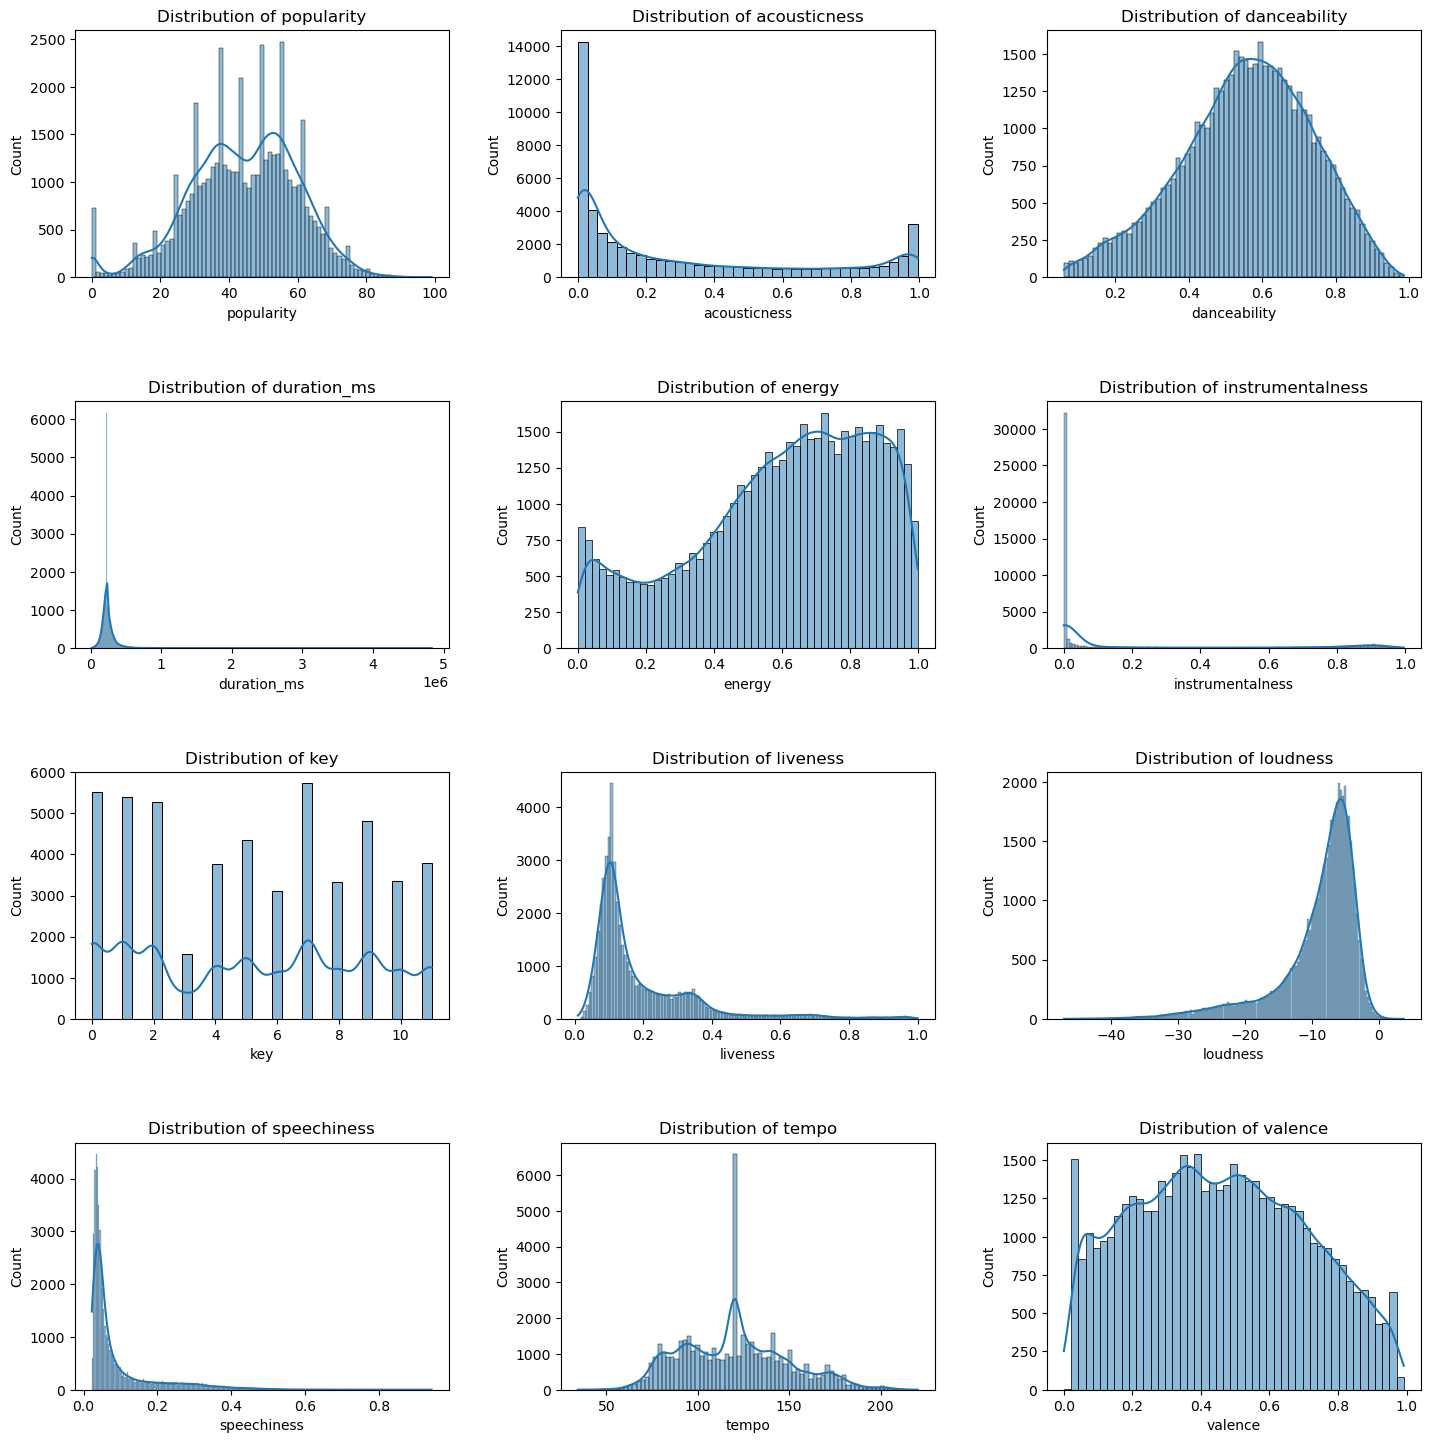

In [11]:
# Check the distribution of festures
features = ['popularity','acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness',
            'key', 'liveness', 'loudness', 'speechiness', 'tempo','valence']

# Create a 4x3 grid for the subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout(pad=4.0)  # Adjust layout for more compact appearance

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(features):
    sns.histplot(data_clean[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Adjust the layout
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [12]:
# Handle right skewed features
data_clean['duration_ms'] = np.log1p(data_clean['duration_ms'])  
data_clean['speechiness'] = np.log1p(data_clean['speechiness'])
data_clean['instrumentalness'] = np.log1p(data_clean['instrumentalness'])
data_clean['liveness'] = np.log1p(data_clean['liveness'])  

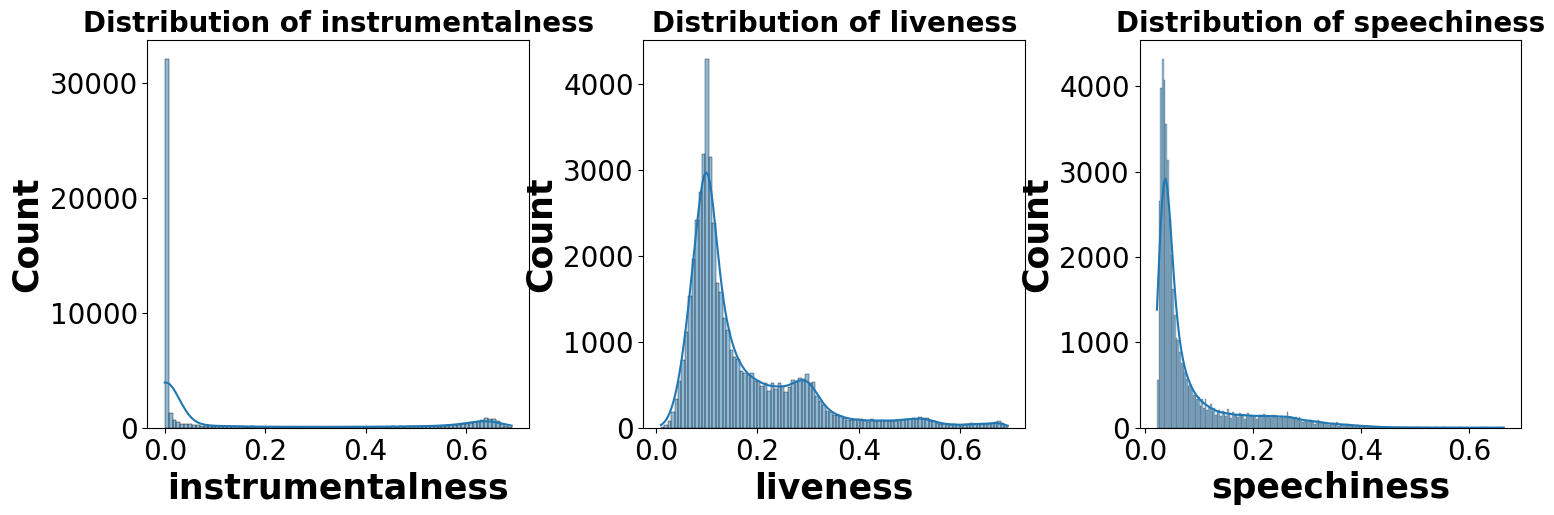

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the features to plot
features = ['instrumentalness', 'liveness', 'speechiness']

# Create a 1x3 grid for the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout(pad=3.0)  # Adjust layout for spacing

# Plot each feature in a subplot
for i, feature in enumerate(features):
    sns.histplot(data_clean[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}', fontsize=20, fontweight='bold') 
    axes[i].set_xlabel(feature, fontsize=25, fontweight='bold')  
    axes[i].set_ylabel('Count', fontsize=25, fontweight='bold') 
    axes[i].tick_params(axis='both', which='major', labelsize=20)  

# Adjust the layout
plt.subplots_adjust(wspace=0.3)  
plt.show()

In [14]:
# omit the mode/key for Standard scaler
numeric_columns = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 
                   'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

scaler = StandardScaler()
data_norm = data_clean.copy()  
data_norm[numeric_columns] = scaler.fit_transform(data_clean[numeric_columns])
data_norm

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,-1.108003,-0.883886,0.524878,-0.016284,1.289876,1.892942,10,-0.502429,0.638132,0,-0.160603,-0.655420,1.225073,1
1,-0.850633,-0.860390,0.356933,-0.132340,1.097101,2.250392,2,-0.435712,0.339248,0,-0.665402,-0.170027,0.302431,1
2,-1.043661,-0.888632,0.345737,-0.167567,0.586813,-0.525121,8,2.145080,0.732892,1,-0.613715,0.276811,-0.498812,1
3,-0.657606,-0.823184,1.207853,-0.898294,0.378918,-0.564057,1,-0.195573,0.752201,1,1.525032,0.277499,-0.753752,1
4,-0.786291,-0.883974,0.446504,-0.079583,-0.048212,2.160498,6,-0.195573,0.465324,1,-0.536034,0.862942,-0.539278,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,0.950954,-0.799746,1.985998,-0.016284,-0.097351,-0.574746,1,-0.472711,0.342655,1,2.076596,-0.753819,-0.510952,10
50001,1.787405,-0.437640,0.843973,0.275558,-0.898692,-0.574746,11,-0.547206,-0.110376,1,-0.381060,0.072137,-1.389081,10
50002,0.436214,-0.880107,0.754403,-0.535970,0.617052,-0.574746,2,-0.296603,0.598865,1,0.599907,0.382915,-0.247918,10
50003,1.337008,-0.654142,1.252639,0.396520,-0.482901,-0.574746,7,-0.569686,0.668150,0,-0.504196,-1.515356,-0.413831,10


In [15]:
X =  data_norm.drop('music_genre', axis=1)
y =  data_norm['music_genre']

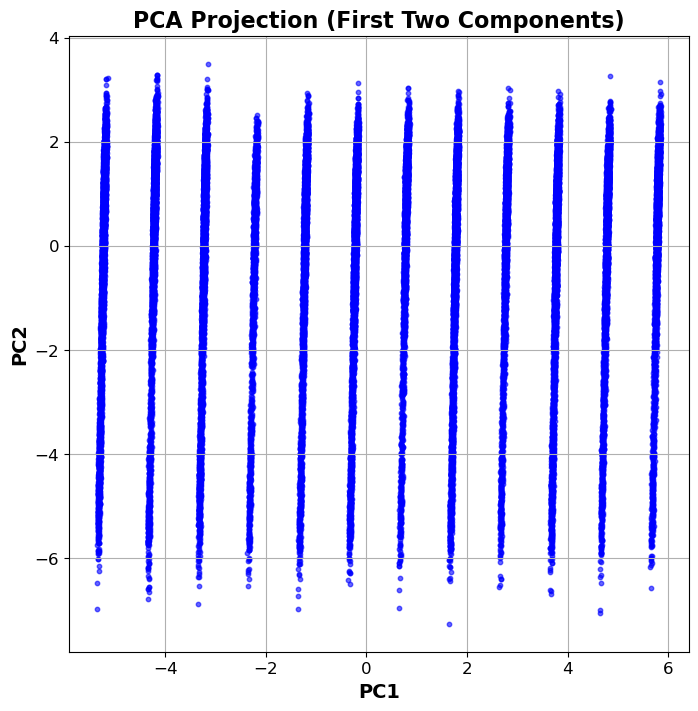

Percentage of variance explained by the first two components is 0.68


In [16]:
# PCA Analysis
pca = PCA()
X_pca = pca.fit_transform(X)
projected_data = X_pca[:, :2]
variance = np.sum(pca.explained_variance_ratio_[:2])

plt.figure(figsize=(8, 8))
plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.6, s=10, c='blue')
plt.xlabel('PC1', fontsize=14, fontweight='bold')
plt.ylabel('PC2', fontsize=14, fontweight='bold')
plt.title('PCA Projection (First Two Components)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

print(f'Percentage of variance explained by the first two components is {variance:.2f}')

/Users/jyz/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


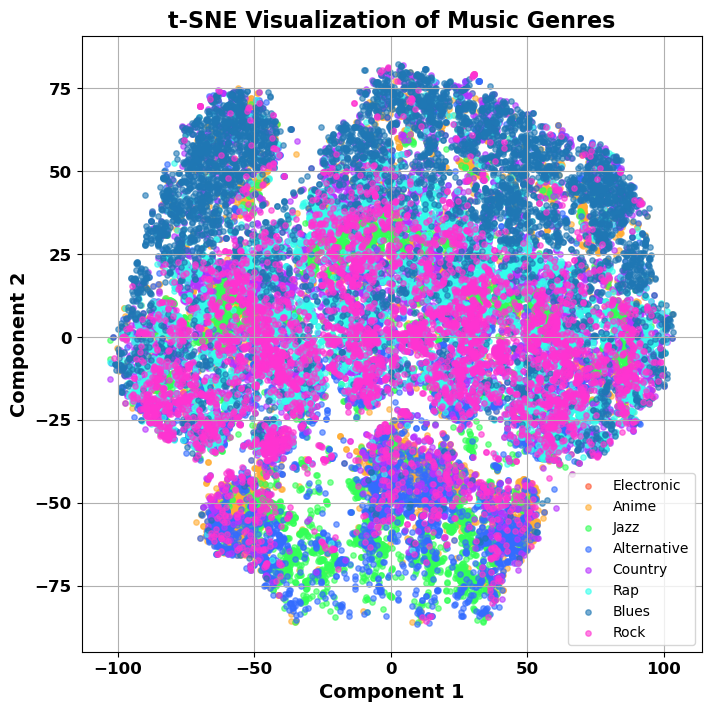

In [17]:
# 2. t-SNE Analysis
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# t-SNE Visualization
plt.figure(figsize=(8, 8))
colors = ['#ff5733', '#ffad33', '#33ff57', '#336cff', '#b833ff', '#33ffec', '#1f77b4', '#ff33d1']

for i, c, label in zip(range(len(genres)), colors, genres):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], c=c, label=label, alpha=0.6, s=15)

plt.xlabel('Component 1', fontsize=14, fontweight='bold')
plt.ylabel('Component 2', fontsize=14, fontweight='bold')
plt.title('t-SNE Visualization of Music Genres', fontsize=16, fontweight='bold')
plt.legend(loc='best', markerscale=1, fontsize=10)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(True)
plt.show()

In [18]:
genre_groups = data_norm.groupby('music_genre')
X_train_list, y_train_list, X_val_list, y_val_list, X_test_list, y_test_list = [], [], [], [], [], []

for genre, group in genre_groups:
    X = group.drop('music_genre', axis=1)
    y = group['music_genre']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=42)  # 1/9 is approximately 10% of the original, leaving 80% for training
    
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_val_list.append(X_val)
    y_val_list.append(y_val)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

X_train = pd.concat(X_train_list)
y_train = pd.concat(y_train_list)
X_val = pd.concat(X_val_list)
y_val = pd.concat(y_val_list)
X_test = pd.concat(X_test_list)
y_test = pd.concat(y_test_list)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (40000, 13)
Validation set shape: (5000, 13)
Testing set shape: (5000, 13)


In [19]:
import pandas as pd
from datasets import Dataset, DatasetDict
from datasets import ClassLabel
import torch
from torch import nn
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader
import accelerate
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
import netron
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import torch.nn.functional as F

In [20]:
# Convert to Series
y_train_smote = y_train.squeeze()
X_train_smote = X_train.squeeze()
y_train_smote = y_train_smote.astype(int)
X_train_smote = X_train_smote.astype(float)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train_smote)

X_train = X_train_resampled
y_train = y_train_resampled

In [21]:
# Combine features and labels for each split
train_df = X_train.copy()
train_df['label'] = y_train.values

val_df = X_val.copy()
val_df['label'] = y_val.values

test_df = X_test.copy()
test_df['label'] = y_test.values

# Create a label mapping
unique_labels = np.unique(train_df['label'])
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Map labels to integers
train_df['label'] = train_df['label'].map(label2id)
val_df['label'] = val_df['label'].map(label2id)
test_df['label'] = test_df['label'].map(label2id)

num_labels = len(unique_labels)
label_feature = ClassLabel(num_classes=num_labels, names=[str(label) for label in unique_labels])

In [22]:
# Compute class weights using 'balanced' mode
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(range(num_labels)),
    y=train_df['label'].values  # Ensure labels are integers
)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Convert class weights to a torch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [23]:
# Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Remove the Pandas index column if it exists
def remove_unused_columns(dataset):
    if '__index_level_0__' in dataset.column_names:
        return dataset.remove_columns(['__index_level_0__'])
    else:
        return dataset

train_dataset = remove_unused_columns(train_dataset)
val_dataset = remove_unused_columns(val_dataset)
test_dataset = remove_unused_columns(test_dataset)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [24]:
# Ensure labels are integers
def encode_labels(example):
    example['label'] = int(example['label'])
    return example

dataset = dataset.map(encode_labels)

# Prepare features (convert to floats)
feature_columns = [col for col in train_df.columns if col != 'label']

def convert_features(example):
    for feature in feature_columns:
        example[feature] = float(example[feature])
    return example

dataset = dataset.map(convert_features)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Initial Model Prediction

In [25]:
class FFNForClassification(nn.Module):
    def __init__(self, input_size, num_classes, class_weights=None, dropout_rate=0.2,
                 hidden_size1=256, hidden_size2=128, hidden_size3=64):
        super(FFNForClassification, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.output_layer = nn.Linear(hidden_size3, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.class_weights = class_weights

    def forward(self, features, labels=None):
        x = F.relu(self.bn1(self.fc1(features)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        logits = self.output_layer(x)
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fn(logits, labels)
        return {'loss': loss, 'logits': logits}

In [26]:
# Data collator function
def data_collator(features):
    # Stack features and labels
    batch = {}
    batch['features'] = torch.tensor([[f[col] for col in feature_columns] for f in features], dtype=torch.float32)
    batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
    return batch

In [27]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    eval_strategy='epoch',
    save_strategy='epoch',  
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=[],
    remove_unused_columns=False,
)

In [28]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    # Apply softmax to logits to get probabilities
    probs = softmax(logits, axis=1)

    # Compute accuracy, precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    # Compute AUC-ROC
    try:
        roc_auc = roc_auc_score(labels, probs, multi_class='ovr')
    except ValueError:
        # This can occur if only one class is present in y_true
        roc_auc = float('nan')

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
    }

In [29]:
# Get input size and number of classes
input_size = len(feature_columns)
num_classes = num_labels

model = FFNForClassification(
    input_size=input_size,
    num_classes=num_classes,
    class_weights=class_weights_tensor
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.806200,1.716584,0.477000,0.480494,0.477000,0.431680,0.872538
2,1.595000,1.508184,0.508800,0.504810,0.508800,0.474845,0.893493
3,1.515300,1.401561,0.526000,0.525793,0.526000,0.499215,0.901323
4,1.463800,1.343626,0.537800,0.542026,0.537800,0.516680,0.905417
5,1.421300,1.313865,0.540800,0.545904,0.540800,0.524301,0.907659
6,1.400300,1.291098,0.545000,0.550743,0.545000,0.529815,0.909328
7,1.391000,1.277761,0.546800,0.553303,0.546800,0.532914,0.910314
8,1.368600,1.268668,0.546200,0.553869,0.546200,0.531963,0.910947
9,1.394200,1.258279,0.548800,0.554710,0.548800,0.535803,0.911686
10,1.379400,1.252872,0.551400,0.553557,0.551400,0.539230,0.911507


TrainOutput(global_step=6250, training_loss=1.5094366027832031, metrics={'train_runtime': 72.274, 'train_samples_per_second': 5534.496, 'train_steps_per_second': 86.477, 'total_flos': 0.0, 'train_loss': 1.5094366027832031, 'epoch': 10.0})

In [31]:
eval_result = trainer.evaluate()
print(eval_result)

{'eval_loss': 1.2528718709945679, 'eval_accuracy': 0.5514, 'eval_precision': 0.5535568407079221, 'eval_recall': 0.5514, 'eval_f1': 0.5392295376204425, 'eval_roc_auc': 0.9115070444444445, 'eval_runtime': 0.3023, 'eval_samples_per_second': 16540.841, 'eval_steps_per_second': 261.345, 'epoch': 10.0}


In [32]:
predictions = trainer.predict(dataset['test'])
print(predictions.metrics)

{'test_loss': 1.2634950876235962, 'test_accuracy': 0.5392, 'test_precision': 0.5364459341910488, 'test_recall': 0.5392, 'test_f1': 0.5256878417327459, 'test_roc_auc': 0.9074680666666666, 'test_runtime': 0.3447, 'test_samples_per_second': 14506.246, 'test_steps_per_second': 229.199}


# Hyperparameter tuning (aptuna)

In [33]:
from transformers import TrainingArguments
import optuna

In [34]:
def objective(trial):
    # Define hyperparameters
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    hidden_size1 = trial.suggest_int('hidden_size1', 128, 512, step=64)
    hidden_size2 = trial.suggest_int('hidden_size2', 64, 256, step=64)
    hidden_size3 = trial.suggest_int('hidden_size3', 32, 128, step=32)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64])

    # Update training parameters
    training_args.learning_rate = learning_rate
    training_args.per_device_train_batch_size = per_device_train_batch_size
    training_args.per_device_eval_batch_size = per_device_train_batch_size

    # Initialze the model
    model = FFNForClassification(
        input_size=input_size,
        num_classes=num_classes,
        class_weights=class_weights_tensor,
        dropout_rate=dropout_rate,
        hidden_size1=hidden_size1,
        hidden_size2=hidden_size2,
        hidden_size3=hidden_size3,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Training model
    trainer.train()
    
    # Evaluate the model on the validation set
    eval_result = trainer.evaluate(eval_dataset=dataset['validation'])
    return eval_result['eval_accuracy']

In [35]:
# Perform a hyperparameter search
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Output the best hyperparameters
print("Best hyperparameters found:")
print(study.best_params)

[I 2024-12-05 20:39:19,465] A new study created in memory with name: no-name-2f766d04-6c38-4f93-9c6b-efa7a188b403


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.453100,1.255892,0.537800,0.538297,0.537800,0.529991,0.911805
2,1.348900,1.194224,0.550400,0.545139,0.550400,0.544059,0.917456
3,1.351400,1.168809,0.560000,0.559491,0.560000,0.554591,0.919940
4,1.312400,1.153283,0.560000,0.560883,0.560000,0.549253,0.921759
5,1.300700,1.151250,0.568200,0.571624,0.568200,0.565517,0.922056
6,1.282100,1.134905,0.569000,0.571031,0.569000,0.565815,0.923765
7,1.292800,1.143243,0.564600,0.569319,0.564600,0.561947,0.923001
8,1.317000,1.135521,0.569800,0.572347,0.569800,0.564962,0.923907
9,1.264700,1.128561,0.569800,0.574619,0.569800,0.566578,0.924615
10,1.300100,1.128407,0.572400,0.572655,0.572400,0.567338,0.924593


[I 2024-12-05 20:41:33,983] Trial 0 finished with value: 0.5724 and parameters: {'dropout_rate': 0.30424293911342715, 'hidden_size1': 320, 'hidden_size2': 192, 'hidden_size3': 96, 'learning_rate': 0.00019179490940610444, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.670200,1.540185,0.491600,0.491868,0.491600,0.468944,0.890757
2,1.476400,1.348765,0.523000,0.516324,0.523000,0.507863,0.904892
3,1.443200,1.276410,0.541600,0.537977,0.541600,0.532444,0.909406
4,1.400700,1.243729,0.549000,0.547252,0.549000,0.539805,0.911934
5,1.374800,1.226210,0.550200,0.549211,0.550200,0.545307,0.913617
6,1.372100,1.212124,0.551800,0.550230,0.551800,0.545987,0.914944
7,1.341300,1.207442,0.552200,0.551851,0.552200,0.546205,0.915463
8,1.334900,1.202845,0.552000,0.551913,0.552000,0.545540,0.915971
9,1.358400,1.195975,0.554800,0.555276,0.554800,0.549565,0.916558
10,1.368500,1.192784,0.551000,0.548611,0.551000,0.545275,0.916473


[I 2024-12-05 20:42:42,077] Trial 1 finished with value: 0.5548 and parameters: {'dropout_rate': 0.3273381922991859, 'hidden_size1': 256, 'hidden_size2': 256, 'hidden_size3': 128, 'learning_rate': 7.041421772485455e-05, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,2.239600,2.149534,0.265400,0.279058,0.265400,0.198285,0.737281
2,2.130500,2.030555,0.329800,0.347083,0.329800,0.265125,0.814748
3,2.066200,1.968530,0.359200,0.387148,0.359200,0.306281,0.842581
4,2.022200,1.916410,0.381400,0.411797,0.381400,0.327485,0.854511
5,1.955200,1.892613,0.409200,0.431736,0.409200,0.362730,0.859261
6,1.932500,1.849916,0.414800,0.439141,0.414800,0.371310,0.865516
7,1.909200,1.828437,0.422800,0.447526,0.422800,0.381026,0.868865
8,1.934100,1.812608,0.427800,0.449520,0.427800,0.387867,0.870735
9,1.912900,1.794248,0.434000,0.449962,0.434000,0.392430,0.873236
10,1.912100,1.778708,0.433200,0.442380,0.433200,0.394486,0.873440


[I 2024-12-05 20:45:15,941] Trial 2 finished with value: 0.434 and parameters: {'dropout_rate': 0.4375466848348808, 'hidden_size1': 256, 'hidden_size2': 192, 'hidden_size3': 32, 'learning_rate': 1.5122558943393042e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,2.204400,2.114768,0.300800,0.297066,0.300800,0.267629,0.738136
2,2.068800,1.950519,0.353400,0.341501,0.353400,0.319500,0.809224
3,1.985100,1.851838,0.400800,0.400799,0.400800,0.375088,0.843256
4,1.875900,1.768090,0.426000,0.424612,0.426000,0.403634,0.858796
5,1.832800,1.731235,0.443400,0.448067,0.443400,0.425676,0.865909
6,1.814600,1.671416,0.459400,0.460982,0.459400,0.439253,0.874436
7,1.757300,1.650857,0.457600,0.470923,0.457600,0.438315,0.875772
8,1.727300,1.620834,0.465400,0.473998,0.465400,0.445563,0.878589
9,1.743400,1.605917,0.474800,0.476144,0.474800,0.458597,0.881376
10,1.760300,1.590595,0.465200,0.465823,0.465200,0.444517,0.880837


[I 2024-12-05 20:50:06,909] Trial 3 finished with value: 0.4748 and parameters: {'dropout_rate': 0.2606950335366486, 'hidden_size1': 128, 'hidden_size2': 64, 'hidden_size3': 128, 'learning_rate': 1.038363130844696e-05, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,2.148400,2.081044,0.316400,0.292172,0.316400,0.287371,0.742279
2,1.983500,1.937462,0.374600,0.354513,0.374600,0.341734,0.811544
3,1.910500,1.833412,0.405400,0.394899,0.405400,0.373613,0.841750
4,1.840200,1.759387,0.429200,0.422770,0.429200,0.400917,0.858425
5,1.774600,1.711046,0.443400,0.435980,0.443400,0.418043,0.869076
6,1.739000,1.667505,0.447600,0.440458,0.447600,0.422653,0.874444
7,1.714600,1.638396,0.456400,0.451207,0.456400,0.431524,0.878264
8,1.693600,1.620668,0.461200,0.458272,0.461200,0.438625,0.880716
9,1.693100,1.604070,0.463600,0.457588,0.463600,0.441685,0.882974
10,1.680700,1.594637,0.462600,0.457480,0.462600,0.438887,0.882484


[I 2024-12-05 20:51:18,157] Trial 4 finished with value: 0.4636 and parameters: {'dropout_rate': 0.1920016717594898, 'hidden_size1': 192, 'hidden_size2': 64, 'hidden_size3': 96, 'learning_rate': 1.5195949939108807e-05, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,2.038700,1.953596,0.338000,0.427935,0.338000,0.282542,0.823531
2,1.858500,1.772788,0.410600,0.460248,0.410600,0.370337,0.865365
3,1.757600,1.651977,0.461800,0.483255,0.461800,0.433529,0.881339
4,1.698300,1.576515,0.486000,0.499261,0.486000,0.462901,0.889649
5,1.640100,1.536103,0.508600,0.516853,0.508600,0.489656,0.892866
6,1.612200,1.489587,0.517000,0.521925,0.517000,0.500596,0.895491
7,1.585300,1.472656,0.513200,0.521254,0.513200,0.494091,0.896966
8,1.573300,1.454951,0.518400,0.525212,0.518400,0.500199,0.898584
9,1.574200,1.436701,0.525000,0.530668,0.525000,0.507910,0.899909
10,1.569100,1.425901,0.518400,0.518538,0.518400,0.500865,0.898991


[I 2024-12-05 20:53:34,304] Trial 5 finished with value: 0.525 and parameters: {'dropout_rate': 0.24686934730578403, 'hidden_size1': 192, 'hidden_size2': 128, 'hidden_size3': 32, 'learning_rate': 3.2701041085021396e-05, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.477200,1.268591,0.532600,0.534421,0.532600,0.522180,0.909434
2,1.433500,1.220132,0.539400,0.533652,0.539400,0.516319,0.916025
3,1.408400,1.197772,0.552800,0.551829,0.552800,0.545488,0.917781
4,1.356200,1.179780,0.564000,0.564921,0.564000,0.553982,0.919691
5,1.380700,1.185976,0.563400,0.568218,0.563400,0.558587,0.918991
6,1.342900,1.168937,0.567400,0.566939,0.567400,0.562340,0.921245
7,1.340000,1.181358,0.564600,0.572789,0.564600,0.556654,0.919647
8,1.366900,1.158042,0.566200,0.567898,0.566200,0.559898,0.921566
9,1.362700,1.162159,0.567200,0.573547,0.567200,0.562818,0.921505
10,1.366300,1.154519,0.566800,0.566221,0.566800,0.560610,0.922422


[I 2024-12-05 20:57:59,525] Trial 6 finished with value: 0.5674 and parameters: {'dropout_rate': 0.3340842397987983, 'hidden_size1': 512, 'hidden_size2': 64, 'hidden_size3': 96, 'learning_rate': 0.00027680722756626315, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,2.139600,1.997900,0.367800,0.366977,0.367800,0.327292,0.826150
2,1.963300,1.795203,0.405200,0.397167,0.405200,0.361530,0.863512
3,1.846300,1.643578,0.454000,0.450584,0.454000,0.421211,0.879332
4,1.774500,1.587523,0.466000,0.464934,0.466000,0.425353,0.885525
5,1.720900,1.532886,0.495600,0.505454,0.495600,0.466396,0.889895
6,1.659500,1.486874,0.488600,0.488761,0.488600,0.458236,0.893998
7,1.668300,1.474262,0.495800,0.503105,0.495800,0.465161,0.894920
8,1.679100,1.442165,0.497200,0.505989,0.497200,0.467391,0.896691
9,1.634000,1.448297,0.502800,0.507187,0.502800,0.475882,0.897633
10,1.653900,1.425813,0.496600,0.497001,0.496600,0.468088,0.896577


[I 2024-12-05 21:02:20,814] Trial 7 finished with value: 0.5028 and parameters: {'dropout_rate': 0.4515836592848811, 'hidden_size1': 256, 'hidden_size2': 64, 'hidden_size3': 64, 'learning_rate': 3.3494719268129474e-05, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,2.134500,2.019080,0.337000,0.348301,0.337000,0.274642,0.807625
2,1.993400,1.855604,0.396600,0.422056,0.396600,0.348905,0.850882
3,1.936500,1.762373,0.441200,0.463027,0.441200,0.405337,0.868180
4,1.830300,1.690378,0.447000,0.462214,0.447000,0.409623,0.877063
5,1.796400,1.650000,0.476400,0.494888,0.476400,0.446290,0.882032
6,1.747200,1.606037,0.476800,0.485313,0.476800,0.449963,0.885031
7,1.751700,1.571064,0.474400,0.492438,0.474400,0.449798,0.886087
8,1.674600,1.555798,0.483400,0.502319,0.483400,0.457606,0.887788
9,1.711800,1.534080,0.484200,0.496449,0.484200,0.456676,0.890497
10,1.704800,1.523887,0.487200,0.498300,0.487200,0.462267,0.889710


[I 2024-12-05 21:06:56,348] Trial 8 finished with value: 0.4872 and parameters: {'dropout_rate': 0.36210280155245056, 'hidden_size1': 128, 'hidden_size2': 256, 'hidden_size3': 96, 'learning_rate': 1.2537158388606107e-05, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.975900,1.872131,0.389200,0.413965,0.389200,0.364640,0.852493
2,1.754300,1.654934,0.461200,0.473590,0.461200,0.439244,0.882964
3,1.639600,1.525268,0.499200,0.506443,0.499200,0.480770,0.893077
4,1.579800,1.451118,0.514000,0.521480,0.514000,0.495588,0.898462
5,1.514900,1.409296,0.518200,0.521606,0.518200,0.504122,0.900935
6,1.504300,1.376013,0.523800,0.525922,0.523800,0.509590,0.902936
7,1.461100,1.361321,0.522600,0.525635,0.522600,0.508285,0.903850
8,1.462800,1.345549,0.523200,0.527481,0.523200,0.508920,0.904644
9,1.469200,1.334383,0.530600,0.532918,0.530600,0.518244,0.905543
10,1.471600,1.326228,0.526000,0.524818,0.526000,0.514861,0.905224


[I 2024-12-05 21:08:07,340] Trial 9 finished with value: 0.5306 and parameters: {'dropout_rate': 0.2992437295522187, 'hidden_size1': 256, 'hidden_size2': 192, 'hidden_size3': 96, 'learning_rate': 3.051684164406433e-05, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 0.5724.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.315300,1.151306,0.570800,0.575475,0.570800,0.568100,0.921883
2,1.229000,1.121178,0.569600,0.570607,0.569600,0.558871,0.925436
3,1.242500,1.098904,0.577400,0.579421,0.577400,0.575463,0.927486
4,1.201400,1.090354,0.579800,0.582323,0.579800,0.576508,0.928181
5,1.188900,1.090242,0.576000,0.581517,0.576000,0.572791,0.928859
6,1.183900,1.069283,0.587000,0.588288,0.587000,0.585289,0.931113
7,1.183500,1.078171,0.589200,0.599095,0.589200,0.588176,0.930263
8,1.200900,1.062456,0.592600,0.595944,0.592600,0.588522,0.931708
9,1.138700,1.057001,0.590400,0.597106,0.590400,0.588972,0.932491
10,1.171900,1.054013,0.590400,0.591984,0.590400,0.588308,0.932888


[I 2024-12-05 21:10:27,664] Trial 10 finished with value: 0.5926 and parameters: {'dropout_rate': 0.13604777019417663, 'hidden_size1': 448, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_rate': 0.0009924374924380496, 'per_device_train_batch_size': 32}. Best is trial 10 with value: 0.5926.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.302400,1.146459,0.568000,0.571960,0.568000,0.565096,0.922164
2,1.209400,1.114694,0.565400,0.563692,0.565400,0.555692,0.925792
3,1.231700,1.094311,0.579000,0.582131,0.579000,0.576859,0.928034
4,1.196100,1.090814,0.583400,0.586447,0.583400,0.581222,0.927964
5,1.165500,1.086202,0.574200,0.579976,0.574200,0.570919,0.929077
6,1.169900,1.068765,0.589000,0.589875,0.589000,0.586788,0.930962
7,1.176500,1.078532,0.583600,0.595636,0.583600,0.582893,0.929888
8,1.183400,1.059625,0.590400,0.594173,0.590400,0.586661,0.931826
9,1.134200,1.053472,0.590200,0.598147,0.590200,0.589179,0.932727
10,1.160100,1.050934,0.591600,0.594281,0.591600,0.589623,0.933089


[I 2024-12-05 21:13:03,681] Trial 11 finished with value: 0.5916 and parameters: {'dropout_rate': 0.10385164080038217, 'hidden_size1': 448, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_rate': 0.000970964852658525, 'per_device_train_batch_size': 32}. Best is trial 10 with value: 0.5926.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.304300,1.144495,0.570200,0.572252,0.570200,0.567171,0.922644
2,1.214300,1.113366,0.569000,0.567021,0.569000,0.561439,0.925968
3,1.243200,1.094919,0.582000,0.585037,0.582000,0.580713,0.927980
4,1.205900,1.085060,0.580600,0.584377,0.580600,0.578597,0.928761
5,1.191800,1.080053,0.578600,0.583381,0.578600,0.576149,0.929886
6,1.190100,1.064535,0.589600,0.591921,0.589600,0.588636,0.931791
7,1.184400,1.074762,0.590600,0.602389,0.590600,0.589275,0.930786
8,1.192600,1.058635,0.592000,0.595536,0.592000,0.590013,0.932127
9,1.131700,1.049829,0.593200,0.601760,0.593200,0.593048,0.933339
10,1.172400,1.046742,0.595200,0.597942,0.595200,0.593712,0.933814


[I 2024-12-05 21:15:15,072] Trial 12 finished with value: 0.5952 and parameters: {'dropout_rate': 0.12519886607105765, 'hidden_size1': 512, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_rate': 0.0009410920716516058, 'per_device_train_batch_size': 32}. Best is trial 12 with value: 0.5952.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.312600,1.153046,0.566800,0.570766,0.566800,0.563220,0.921585
2,1.225100,1.121848,0.567600,0.565722,0.567600,0.557609,0.925310
3,1.235100,1.097798,0.578600,0.579983,0.578600,0.576075,0.927574
4,1.200700,1.091630,0.579000,0.581216,0.579000,0.575959,0.928107
5,1.175300,1.086857,0.574600,0.580026,0.574600,0.572203,0.929040
6,1.176500,1.069688,0.588000,0.589289,0.588000,0.586405,0.931131
7,1.183000,1.077824,0.593000,0.603539,0.593000,0.591553,0.930214
8,1.199000,1.061478,0.591200,0.595212,0.591200,0.587494,0.931907
9,1.128400,1.055724,0.590400,0.598130,0.590400,0.589984,0.932640
10,1.175400,1.051516,0.591800,0.593867,0.591800,0.589451,0.933166


[I 2024-12-05 21:17:27,716] Trial 13 finished with value: 0.593 and parameters: {'dropout_rate': 0.12662178978368963, 'hidden_size1': 448, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_rate': 0.0008799463064654528, 'per_device_train_batch_size': 32}. Best is trial 12 with value: 0.5952.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.391400,1.212501,0.548200,0.548232,0.548200,0.541464,0.915340
2,1.298400,1.165622,0.553800,0.549223,0.553800,0.546086,0.920069
3,1.319900,1.140330,0.567200,0.567942,0.567200,0.563168,0.922933
4,1.270400,1.131047,0.572200,0.574041,0.572200,0.564736,0.923534
5,1.277200,1.123008,0.571000,0.573581,0.571000,0.568358,0.925163
6,1.250800,1.106991,0.576800,0.578963,0.576800,0.574822,0.926922
7,1.238800,1.117351,0.574000,0.580081,0.574000,0.571015,0.925818
8,1.279800,1.104113,0.581600,0.584530,0.581600,0.579075,0.927097
9,1.229600,1.096215,0.583000,0.589280,0.583000,0.580683,0.928038
10,1.270300,1.096192,0.578200,0.579122,0.578200,0.575533,0.928080


[I 2024-12-05 21:19:36,145] Trial 14 finished with value: 0.583 and parameters: {'dropout_rate': 0.19070270790888572, 'hidden_size1': 512, 'hidden_size2': 128, 'hidden_size3': 32, 'learning_rate': 0.00047172902369467783, 'per_device_train_batch_size': 32}. Best is trial 12 with value: 0.5952.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.355300,1.180772,0.557800,0.559873,0.557800,0.554394,0.918093
2,1.247300,1.139535,0.561600,0.559376,0.561600,0.556202,0.923076
3,1.273400,1.122241,0.574400,0.576251,0.574400,0.571902,0.924890
4,1.257300,1.113685,0.574600,0.578038,0.574600,0.566950,0.925701
5,1.223000,1.106741,0.572800,0.577399,0.572800,0.570074,0.926602
6,1.216900,1.090056,0.579400,0.581767,0.579400,0.578724,0.928356
7,1.195400,1.102266,0.579200,0.587526,0.579200,0.575757,0.927112
8,1.229300,1.087460,0.580600,0.584689,0.580600,0.577834,0.928534
9,1.176400,1.080257,0.576000,0.581622,0.576000,0.574607,0.929500
10,1.231100,1.078705,0.582200,0.582917,0.582200,0.578615,0.929749


[I 2024-12-05 21:21:54,033] Trial 15 finished with value: 0.5822 and parameters: {'dropout_rate': 0.16518682090983214, 'hidden_size1': 384, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_rate': 0.00047907821030396025, 'per_device_train_batch_size': 32}. Best is trial 12 with value: 0.5952.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.365800,1.185721,0.552000,0.555101,0.552000,0.542531,0.917817
2,1.256500,1.143642,0.559400,0.556553,0.559400,0.552747,0.922387
3,1.296800,1.123819,0.572000,0.572412,0.572000,0.568444,0.924880
4,1.252700,1.112744,0.574200,0.576585,0.574200,0.568359,0.925988
5,1.236800,1.104612,0.572200,0.575732,0.572200,0.569739,0.927223
6,1.224600,1.091037,0.580400,0.582310,0.580400,0.578996,0.928745
7,1.220400,1.103165,0.574400,0.582068,0.574400,0.572453,0.927435
8,1.247900,1.085894,0.586000,0.590302,0.586000,0.583449,0.929105
9,1.204200,1.078998,0.581400,0.588453,0.581400,0.579445,0.929996
10,1.233100,1.076763,0.581800,0.583645,0.581800,0.579526,0.930282


[I 2024-12-05 21:24:04,235] Trial 16 finished with value: 0.586 and parameters: {'dropout_rate': 0.2273938516282346, 'hidden_size1': 448, 'hidden_size2': 192, 'hidden_size3': 64, 'learning_rate': 0.0005118180127408927, 'per_device_train_batch_size': 32}. Best is trial 12 with value: 0.5952.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.484600,1.343172,0.530800,0.533572,0.530800,0.519684,0.909027
2,1.323400,1.226669,0.555200,0.550539,0.555200,0.550606,0.915871
3,1.335600,1.183321,0.561200,0.559814,0.561200,0.556712,0.919221
4,1.291600,1.165123,0.562200,0.564054,0.562200,0.556769,0.920507
5,1.273300,1.158897,0.565200,0.568672,0.565200,0.564001,0.921763
6,1.256300,1.140644,0.568000,0.569208,0.568000,0.564016,0.923428
7,1.268700,1.145849,0.571000,0.575853,0.571000,0.568732,0.922933
8,1.276700,1.134202,0.570600,0.573393,0.570600,0.567372,0.924183
9,1.235200,1.126130,0.571800,0.575696,0.571800,0.568861,0.925023
10,1.283300,1.127097,0.572000,0.571681,0.572000,0.568046,0.924788


[I 2024-12-05 21:26:19,210] Trial 17 finished with value: 0.572 and parameters: {'dropout_rate': 0.10461736457049804, 'hidden_size1': 384, 'hidden_size2': 128, 'hidden_size3': 32, 'learning_rate': 0.0001446130973439202, 'per_device_train_batch_size': 32}. Best is trial 12 with value: 0.5952.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.355800,1.187097,0.554400,0.556136,0.554400,0.550999,0.917768
2,1.248800,1.142503,0.564800,0.561091,0.564800,0.559839,0.922756
3,1.274600,1.122185,0.576600,0.578349,0.576600,0.572783,0.924834
4,1.238500,1.112627,0.569800,0.573194,0.569800,0.562225,0.925594
5,1.222000,1.105611,0.574800,0.577863,0.574800,0.572054,0.926809
6,1.214300,1.092530,0.582200,0.584175,0.582200,0.579869,0.928172
7,1.197800,1.102293,0.576400,0.584067,0.576400,0.573847,0.927305
8,1.237800,1.087482,0.581800,0.585064,0.581800,0.578488,0.928646
9,1.173100,1.080450,0.580200,0.586537,0.580200,0.579400,0.929384
10,1.224300,1.080935,0.583400,0.584988,0.583400,0.579924,0.929516


[I 2024-12-05 21:28:27,855] Trial 18 finished with value: 0.5834 and parameters: {'dropout_rate': 0.1617410029325687, 'hidden_size1': 512, 'hidden_size2': 192, 'hidden_size3': 64, 'learning_rate': 0.00032396783242661054, 'per_device_train_batch_size': 32}. Best is trial 12 with value: 0.5952.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.959800,1.838489,0.409400,0.438671,0.409400,0.401973,0.856371
2,1.762500,1.638061,0.466600,0.457099,0.466600,0.439221,0.883706
3,1.681200,1.513798,0.485200,0.465397,0.485200,0.440700,0.892570
4,1.626300,1.458134,0.499200,0.487519,0.499200,0.459141,0.897225
5,1.597400,1.424885,0.503000,0.502237,0.503000,0.478876,0.899544
6,1.568700,1.394555,0.510400,0.508677,0.510400,0.488410,0.901234
7,1.563800,1.382076,0.511600,0.510303,0.511600,0.490923,0.902099
8,1.540300,1.367512,0.516400,0.515527,0.516400,0.494723,0.902499
9,1.552700,1.357128,0.519000,0.516919,0.519000,0.499765,0.903457
10,1.534900,1.351478,0.517200,0.512112,0.517200,0.497799,0.903498


[I 2024-12-05 21:29:39,266] Trial 19 finished with value: 0.519 and parameters: {'dropout_rate': 0.4112680169848576, 'hidden_size1': 384, 'hidden_size2': 64, 'hidden_size3': 32, 'learning_rate': 8.570713821799415e-05, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 0.5952.


Best hyperparameters found:
{'dropout_rate': 0.12519886607105765, 'hidden_size1': 512, 'hidden_size2': 128, 'hidden_size3': 64, 'learning_rate': 0.0009410920716516058, 'per_device_train_batch_size': 32}


In [36]:
# Retrain the model using optimal hyperparameters
best_params = study.best_params

# Update training parameters
training_args.learning_rate = best_params['learning_rate']
training_args.per_device_train_batch_size = best_params['per_device_train_batch_size']
training_args.per_device_eval_batch_size = best_params['per_device_train_batch_size']

# Initialize model
model = FFNForClassification(
    input_size=input_size,
    num_classes=num_classes,
    class_weights=class_weights_tensor,
    dropout_rate=best_params['dropout_rate'],
    hidden_size1=best_params['hidden_size1'],
    hidden_size2=best_params['hidden_size2'],
    hidden_size3=best_params['hidden_size3'],
)

# Create a new Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,1.304300,1.144495,0.570200,0.572252,0.570200,0.567171,0.922644
2,1.214300,1.113366,0.569000,0.567021,0.569000,0.561439,0.925968
3,1.243200,1.094919,0.582000,0.585037,0.582000,0.580713,0.927980
4,1.205900,1.085060,0.580600,0.584377,0.580600,0.578597,0.928761
5,1.191800,1.080053,0.578600,0.583381,0.578600,0.576149,0.929886
6,1.190100,1.064535,0.589600,0.591921,0.589600,0.588636,0.931791
7,1.184400,1.074762,0.590600,0.602389,0.590600,0.589275,0.930786
8,1.192600,1.058635,0.592000,0.595536,0.592000,0.590013,0.932127
9,1.131700,1.049829,0.593200,0.601760,0.593200,0.593048,0.933339
10,1.172400,1.046742,0.595200,0.597942,0.595200,0.593712,0.933814


TrainOutput(global_step=12500, training_loss=1.2044217910766601, metrics={'train_runtime': 125.7937, 'train_samples_per_second': 3179.809, 'train_steps_per_second': 99.369, 'total_flos': 0.0, 'train_loss': 1.2044217910766601, 'epoch': 10.0})

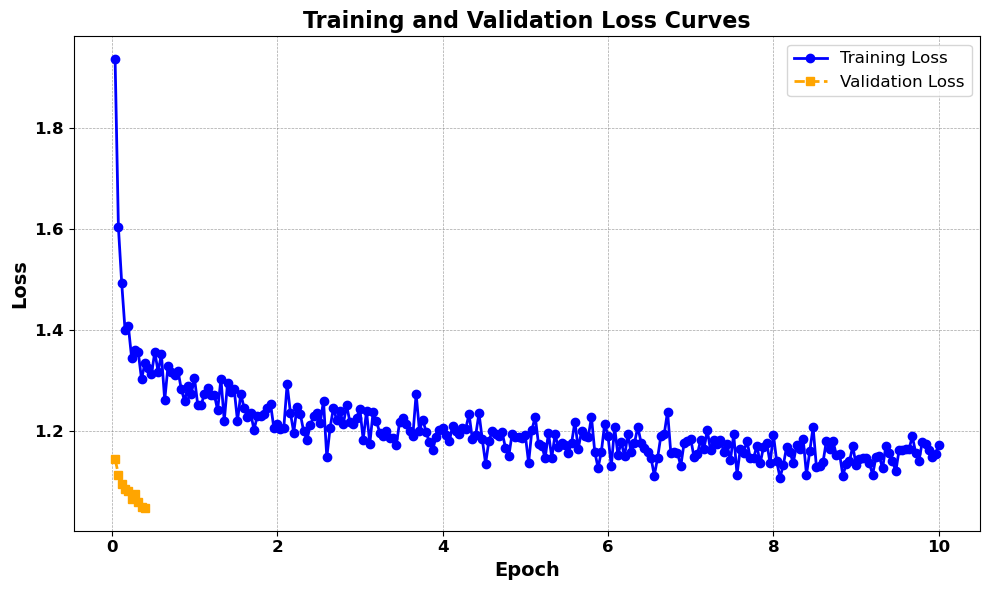

In [37]:
# Get training log
training_logs = trainer.state.log_history

# Extract training and validation losses
train_loss = []
eval_loss = []
epochs = []

for log in training_logs:
    if 'loss' in log.keys():
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    elif 'eval_loss' in log.keys():
        eval_loss.append(log['eval_loss'])

# Plot Training and Validation Loss Curves
plt.figure(figsize=(10, 6))  # Larger figure for better visibility
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss', linewidth=2, marker='o', color='blue')  # Add markers and line width
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss', linewidth=2, linestyle='--', marker='s', color='orange')

# Labels and Title
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss Curves', fontsize=16, fontweight='bold')

# Add Legend and Grid
plt.legend(fontsize=12, loc='upper right')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust Tick Labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Tight Layout
plt.tight_layout()
plt.show()

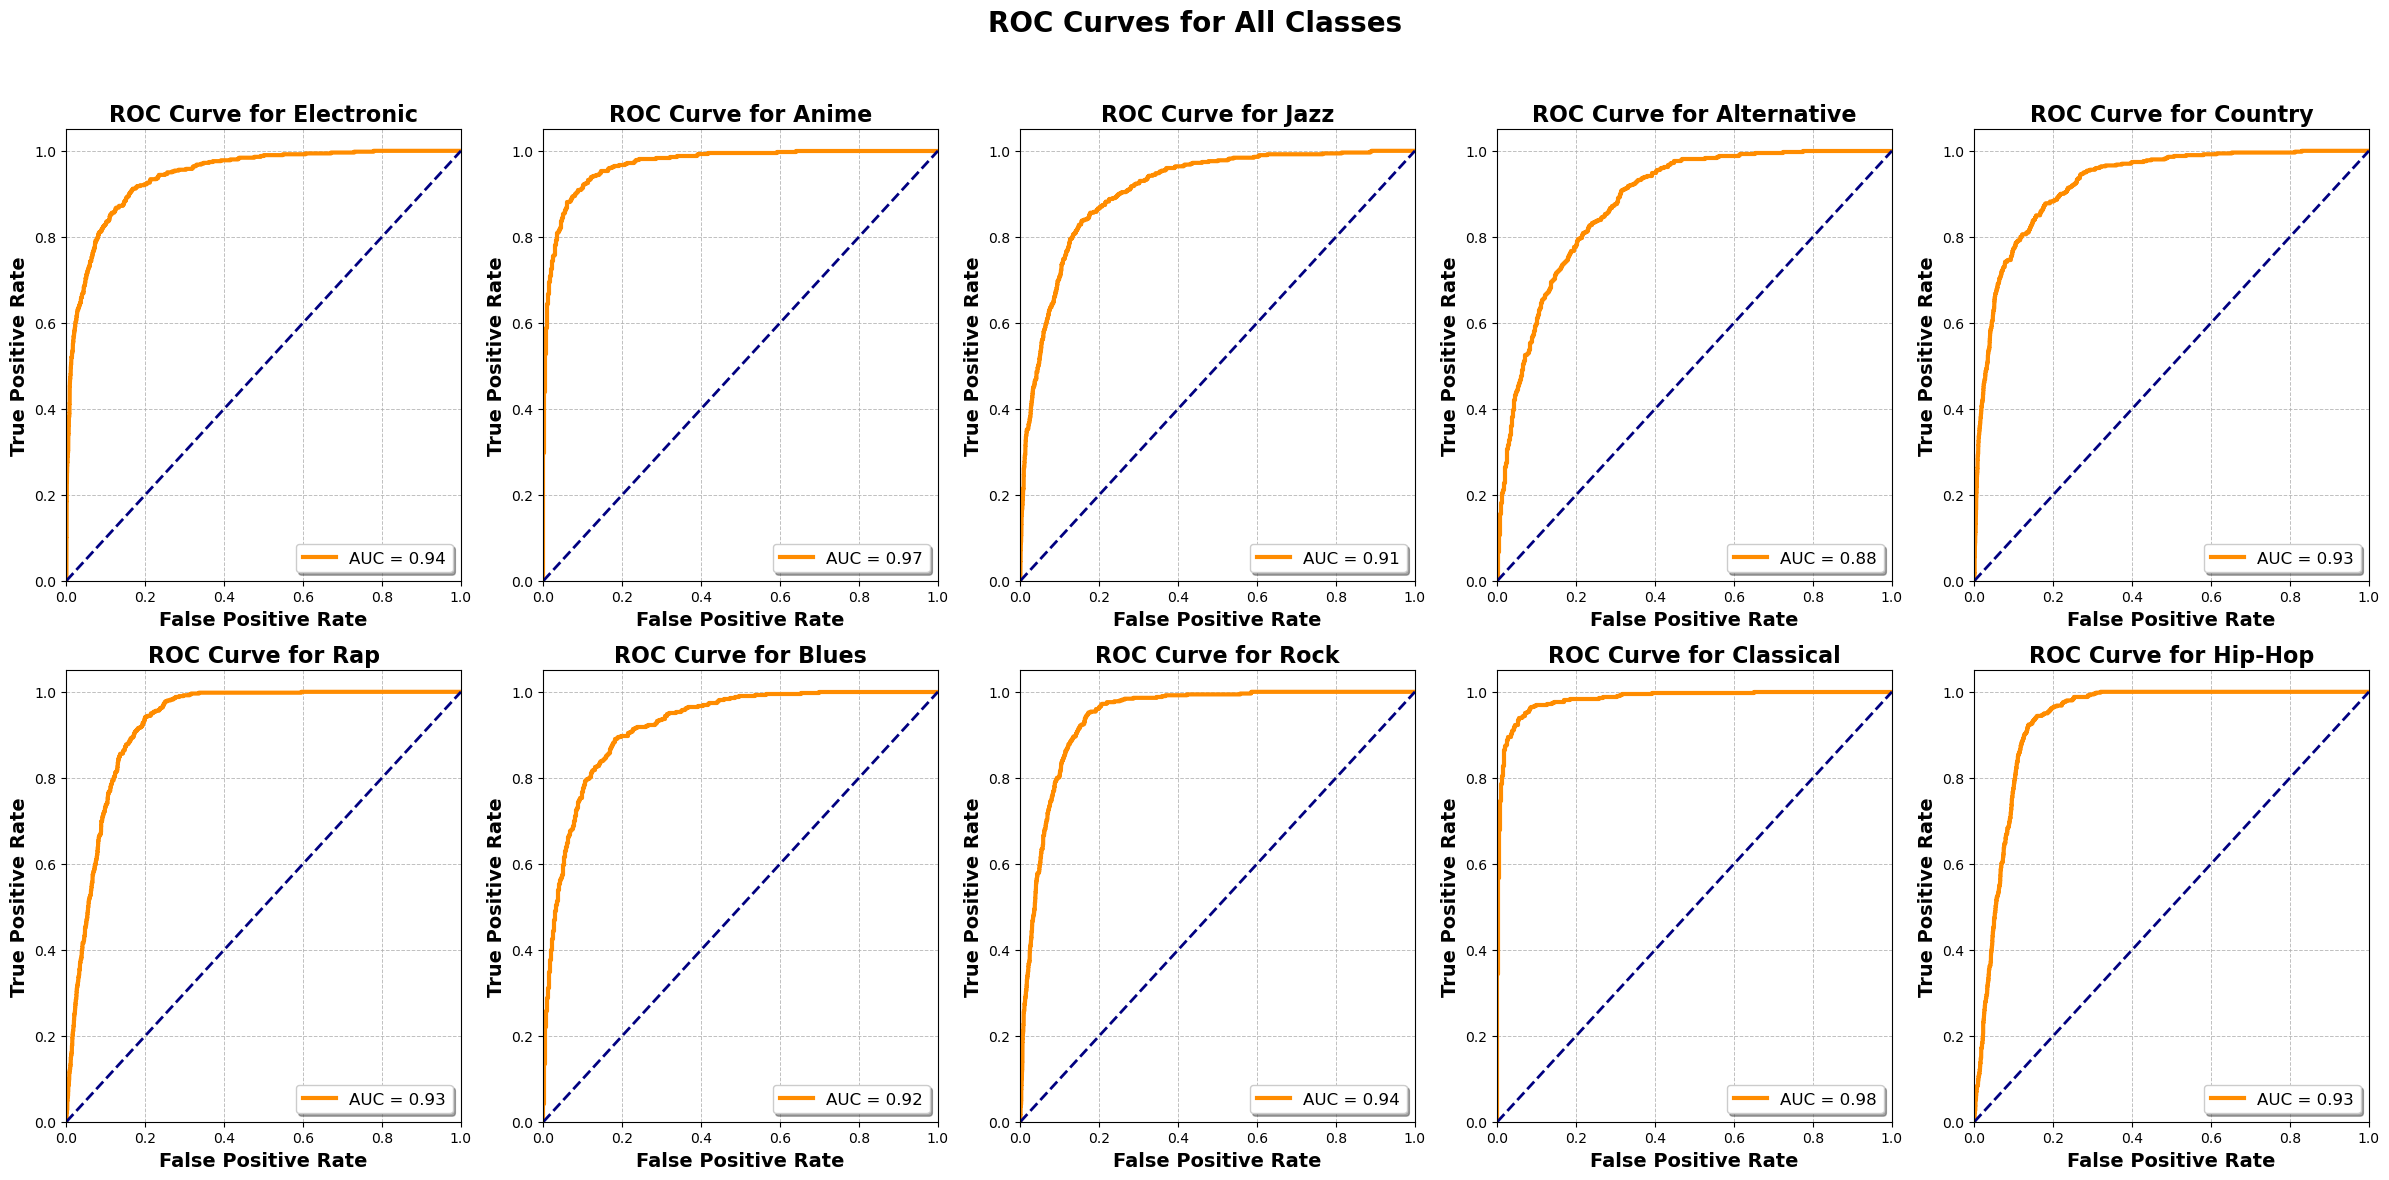

In [38]:
# Obtain predictions on the validation or test set
predictions = trainer.predict(dataset['validation'])

# Extract logits and true labels
logits = predictions.predictions
labels = predictions.label_ids

# Compute probabilities
probs = softmax(logits, axis=1)

# Get the number of classes
num_classes = logits.shape[1]

# Convert labels to one-hot encoding
labels_one_hot = label_binarize(labels, classes=list(range(num_classes)))

# Define the list of class names (customize according to your actual class names)
genre_names = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country',
               'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop']

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 12))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.6)

# Plot the ROC curve for each class
for class_idx in range(num_classes):
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(labels_one_hot[:, class_idx], probs[:, class_idx])
    roc_auc = auc(fpr, tpr)
    
    # Determine the position of the current subplot
    row = class_idx // 5
    col = class_idx % 5
    
    # Plot on the corresponding subplot
    ax = axes[row, col]
    ax.plot(fpr, tpr, color='darkorange', lw=3, label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    ax.set_title(f'ROC Curve for {genre_names[class_idx]}', fontsize=16, fontweight='bold')
    ax.legend(loc='lower right', fontsize=12, frameon=True, shadow=True, fancybox=True)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)

# Add an overall title for the entire figure
fig.suptitle('ROC Curves for All Classes', fontsize=20, fontweight='bold')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

# Hugging Face

In [39]:
import torch
import os
import shutil
import json
from huggingface_hub import notebook_login, HfApi, Repository

In [40]:
# Save the entire model
torch.save(model, 'model.pt')

# Save the model state dictionary
torch.save(model.state_dict(), 'model.pth')

# Launch Netron to visualize the model
netron.start('model.pt')

Serving 'model.pt' at http://localhost:8080


('localhost', 8080)

In [41]:
trainer.save_model('Hugging_Face')

In [42]:
notebook_login()

username = 'JyzJiang'  # Replace with your actual username
repo_name = 'music-genre-classifier'  # Choose a repository name
repo_id = f"{username}/{repo_name}"

api = HfApi()
api.create_repo(repo_id=repo_id, repo_type='model', exist_ok=True)

RepoUrl('https://huggingface.co/JyzJiang/music-genre-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='JyzJiang/music-genre-classifier')

In [44]:
# Create a config file to store model architecture and training parameters if needed
config = {
    'input_size': input_size,
    'num_classes': num_classes
}
with open('config.json', 'w') as f:
    json.dump(config, f)

# Define your repository name
repo_name = 'music-genre-classifier' 

# Clone your repository if not already cloned
repo_url = f"https://huggingface.co/{'JyzJiang'}/{repo_name}"

# Clone or open the local repository folder
if not os.path.isdir(repo_name):
    repo = Repository(local_dir=repo_name, clone_from=repo_url)
else:
    repo = Repository(local_dir=repo_name)

# Copy your model files into the repository directory
shutil.copy('model.pth', repo_name)
shutil.copy('config.json', repo_name)

# Verify files in the repository directory
print("Files in repository directory:", os.listdir(repo_name))

# Once all files are in the repository directory, push them to the Hub.
repo.push_to_hub(commit_message="Add model, config, and code files")

/Users/jyz/anaconda3/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
